In [77]:
using Flux
using Plots

nbatch = 50
N = 1000
mu = Float32.(transpose(rand(nbatch))) #Unif[0,1]
nu = Float32.(transpose(floor.(rand(nbatch) * (N+1)) / N)) #Uniform{0,1/N,...,1}

f = Chain(Dense(1, 20, relu), Dense(20, 10, relu), Dense(10, 1, sigmoid));

In [78]:
using Flux:train!
using Statistics

function loss(f, mu, nu)
    -(mean(f(mu)) - mean(f(nu)))
end

function pred_WassersteinDist(f, mu, nu)
    -loss(f, mu, nu)
end

opt = Flux.setup(Adam(), f) 

epochs = 50
d = [pred_WassersteinDist(f, mu, nu)]

for i in 1:epochs
    data = collect(zip(mu, nu))
    datanew = [([x],[y]) for (x,y) in data]
    Flux.train!(loss, f, datanew, opt) #ENFORCE WEIGHT CLIPPING
    push!(d, pred_WassersteinDist(f, mu, nu))
end


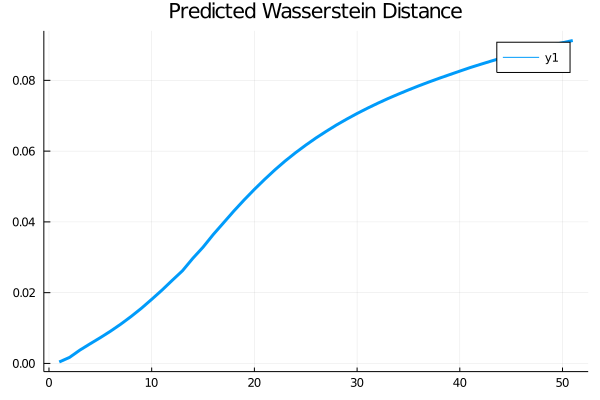

In [79]:
plot(d, title = "Predicted Wasserstein Distance", linewidth=3)

In [80]:
println("Wasserstein Distance: ", 1/N)

println("Predicted Distance: ", pred_WassersteinDist(f, mu, nu))

Wasserstein Distance: 0.01
Predicted Distance: 0.09125787
